In [28]:
# Standard Imports
import itertools
import re
import numpy as np
from html import unescape
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as pp

# Spark Imports
import pyspark
from pyspark import SparkContext
from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel, LogisticRegressionWithLBFGS
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.feature import HashingTF,IDF
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.util import MLUtils

In [2]:
# Training and Testing Data
training_file_data = sc.textFile("data/train.csv")
testing_file_data = sc.textFile("data/test.csv")

# Preprocessing Steps:

1. Lowercase all characters
2. Stemming using Porter Stemmer
3. Strip punctuations
4. Replace two or more occurrences of the same character with two occurrences. i.e. ‘exciteddddd’ to ‘excitedd’
5. Replace Hash tags, ex. #xyz with xyz
6. Replace a word contains www. or http(s):// with URL
7. Replace a word contains @someuser with AT_USER
8. Ignore words that don’t start with an alphabet
9. Ignore stop words
10. Use html.unescape to replace html escape characters and replace with their meaning
11. Replace aposthope characters apostrophes to standard lexicons

In [3]:
def html_parser(tweet):
    return unescape(tweet)


def remove_appostophes(tweet):
    appostophes = {"s": "is", "re": "are", "em": "them", "ll": "will", "t": "it", "m": "am", "ve": "have", "d": "did"}
    words = []
    [words.append(terms) for word in tweet.split() for terms in [appostophes[term] if term in appostophes else term for
                                                                 term in word.split("'")]]
    return " ".join(words)


def remove_stopwords(tweet):
    return " ".join([term for term in tweet.lower().split(" ") if term not in open("data/stopwords.txt", "r").read().
                    split()])

def alpha_check(tweet):
    return " ".join([term for term in tweet.split() if re.match('^[a-zA-Z]+.*', term[0])])


# def split_attached_words(tweet):
#     return " ".join(re.findall('[A-Z][^A-Z]*', tweet))


def strip_usernames(tweet):
    return re.sub('(?:@[\w]+)', '', tweet)


def strip_urls(tweet):
    return re.sub('http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', '', tweet)


def strip_hashes(tweet):
    return " ".join([word[1:] if word.startswith('#') else word for word in tweet.split()])


def strip_numbers(tweet):
    return re.sub('(?:(t?:\d+,?)+(?:\.?\d+)?)', '', tweet)


def strip_punctuation(tweet):
    return " ".join(RegexpTokenizer(r'\w+').tokenize(tweet))


def stemming(tweet):
    return " ".join(PorterStemmer().stem(word) for word in tweet.split())
    # return " ".join(SnowballStemmer("english").stem(word) for word in tweet.split())


def strip_repeated_letters(tweet):
    # return re.sub('([a-z])\1+', '\1', tweet)
    return "".join("".join(s)[:2] for _, s in itertools.groupby(tweet))

In [4]:
def preprocessed_text(tweet_text):
    cleaned_text = html_parser(tweet_text)
    cleaned_text = strip_usernames(cleaned_text)
    cleaned_text = strip_urls(cleaned_text)
    cleaned_text = strip_hashes(cleaned_text)
    cleaned_text = strip_numbers(cleaned_text)
    cleaned_text = strip_punctuation(cleaned_text)
    cleaned_text = remove_appostophes(cleaned_text)
    cleaned_text = remove_stopwords(cleaned_text)
    cleaned_text = alpha_check(cleaned_text)
    cleaned_text = strip_repeated_letters(cleaned_text)
    cleaned_text = stemming(cleaned_text)
    splitted_text = cleaned_text.split()
#     print(splitted_text)
    return splitted_text

In [5]:
def testing_hashing_tf(tweet):
    line = tweet.split(",", 5)
    polarity = line[0][1]
    testing_tweet_text = preprocessed_text(line[-1])
    
    test_hashing_tf = HashingTF()
    test_tf = test_hashing_tf.transform(testing_tweet_text)
    return LabeledPoint(polarity,test_tf)

def preprocessed_text_wrapper(single_line):
    return preprocessed_text(single_line.split(",",5)[-1])

In [6]:
def tfidf():
    tweet_text = training_file_data.map(preprocessed_text_wrapper)
    tweet_polarity = training_file_data.map(lambda line: line.split(",",1)[0][1])

    hashingtf = HashingTF()
    tf = hashingtf.transform(tweet_text)

    tf.cache()
    idf = IDF().fit(tf)
    tfidf = idf.transform(tf)

    zipped_list = tweet_polarity.zip(tfidf)
    return zipped_list.map(lambda x: LabeledPoint(x[0],x[1]))

# Training on train.csv and testing on test.csv

# Naive Bayes 

## Train the model:

In [14]:
testing_data = testing_file_data.map(testing_hashing_tf)
training_data = tfidf()
model = NaiveBayes.train(training_data, 1.0)

## Predict the labels and print accuracy:

In [17]:
predictionAndLabel_naive_test = testing_data.map(lambda p: (float(model.predict(p.features)), p.label))
naive_test_accuracy = 100.0 * predictionAndLabel_naive_test.filter(lambda x: x[0] == x[1]).count() / testing_data.count()
naive_test_accuracy

74.3732590529248

## Metrics for the model - precision, recall, f-measure, Confusion Matrix, ROC,area under ROC,area under Precision_Recall Curve 

In [16]:
metrics_Naive_Test = MulticlassMetrics(predictionAndLabel_naive_test)
metrics1_Naive_Test = BinaryClassificationMetrics(predictionAndLabel_naive_test)
print("Precision = %s" % metrics_Naive_Test.precision())
print("Recall = %s" % metrics_Naive_Test.recall())
print("F-1 Measure = %s" % metrics_Naive_Test.fMeasure())
print("Confusion Matrix = %s\n" % metrics_Naive_Test.confusionMatrix())
print("Area under ROC = %s" % metrics1_Naive_Test.areaUnderROC)
print("Area under PR = %s" % metrics1_Naive_Test.areaUnderPR)

Precision = 0.7437325905292479
Recall = 0.7437325905292479
F-1 Measure = 0.7437325905292479
Confusion Matrix = DenseMatrix([[ 138.,   39.],
             [  53.,  129.]])

Area under ROC = 0.7442261128701807
Area under PR = 0.8121403318130337


# Logistic Regression

## Train the model:

In [18]:
testing_data = testing_file_data.map(testing_hashing_tf)
training_data = tfidf()
model = LogisticRegressionWithLBFGS.train(training_data, iterations = 150 )

## Predict the labels and print accuracy:

In [24]:
truePositiveRate_list = []
falsePositiveRate_list = []
MaxAccuracy = 0
ThresholdValue = 0
for i in range(0,50,2):
    model.setThreshold(i/100)
    predictionAndLabel_log_test = testing_data.map(lambda p: (float(model.predict(p.features)), p.label))
    
    correct1 = 0
    trueP = 0
    falseP = 0
    trueN = 0
    falseN = 0
    
    for item in predictionAndLabel_log_test.collect():
        if item[0] == item[1]:
            correct1 += 1
        if item[0] == 0 and item[1] == 0:
            trueN+= 1
        elif item[0] == 1 and item[1] == 0:
            falseP += 1
        elif item[0] ==  1 and item[1] == 1:
            trueP += 1
        else:
            falseN += 1

    truePositiveRate = trueP / (trueP + falseN)
    falsePostiveRate = falseP / (falseP + trueN)
    truePositiveRate_list.append(truePositiveRate)
    falsePositiveRate_list.append(falsePostiveRate)
    logistic_test_acurracy = correct1/len(testing_data.collect())
    if logistic_test_acurracy > MaxAccuracy:
        maxaccuracy = logistic_test_acurracy
        ThresholdValue = i/100
        precision = truePositiveRate
        recall = trueP/trueP + falseN
logistic_test_acurracy

0.7632311977715878

## Metrics for the model - precision, recall, f-measure, Confusion Matrix,area under ROC,area under Precision_Recall Curve 

In [22]:
metrics_Log_Test = MulticlassMetrics(predictionAndLabel_log_test)
metrics1_Log_Test = BinaryClassificationMetrics(predictionAndLabel_log_test)
print("Precision = %s" % metrics_Log_Test.precision())
print("Recall = %s" % metrics_Log_Test.recall())
print("F-1 Measure = %s" % metrics_Log_Test.fMeasure())
print("Confusion Matrix = %s" % metrics_Log_Test.confusionMatrix())
print("Area under ROC = %s" % metrics1_Log_Test.areaUnderROC)
print("Area under PR = %s" % metrics1_Log_Test.areaUnderPR)

Precision = 0.7632311977715878
Recall = 0.7632311977715878
F-1 Measure = 0.7632311977715878
Confusion Matrix = DenseMatrix([[ 122.,   55.],
             [  30.,  152.]])
Area under ROC = 0.7622151859439995
Area under PR = 0.8265149058415379


# Training on full train.csv data and testing on it too

# Naive Bayes

In [60]:
training_data = tfidf()
model = NaiveBayes.train(training_data, 1.0)
predictionAndLabel_naive_train = training_data.map(lambda p: (float(model.predict(p.features)), p.label))
naive_bayes_training_accuracy = 1.0 * predictionAndLabel_naive_train.filter(lambda x: x[0] == x[1]).count() / training_data.count()
naive_bayes_training_accuracy

0.835825

## Metrics for this prediction


In [61]:
metrics_naive_train = MulticlassMetrics(predictionAndLabel_naive_train)
metrics1_naive_train = BinaryClassificationMetrics(predictionAndLabel_naive_train)
print("Precision = %s" % metrics_naive_train.precision())
print("Recall = %s" % metrics_naive_train.recall())
print("F-1 Measure = %s" % metrics_naive_train.fMeasure())
print("Confusion Matrix = %s" % metrics_naive_train.confusionMatrix())
print("Area under ROC = %s" % metrics1_naive_train.areaUnderROC)
print("Area under PR = %s" % metrics1_naive_train.areaUnderPR)

Precision = 0.835825
Recall = 0.835825
F-1 Measure = 0.835825
Confusion Matrix = DenseMatrix([[ 34475.,   5525.],
             [  7609.,  32391.]])
Area under ROC = 0.835825
Area under PR = 0.8795853261156241


# Logistic Regression

In [62]:
training_data = tfidf()
model = LogisticRegressionWithLBFGS.train(training_data, iterations = 150 )
predictionAndLabel_log_train = training_data.map(lambda p: (float(model.predict(p.features)), p.label))
log_training_accuracy = 1.0 * predictionAndLabel_naive_train.filter(lambda x: x[0] == x[1]).count() / training_data.count()
log_training_accuracy

0.8747375

## Metrics for this prediction

In [63]:
metrics_Log_Train = MulticlassMetrics(predictionAndLabel_log_train)
metrics1_Log_Train = BinaryClassificationMetrics(predictionAndLabel_log_train)
print("Precision = %s" % metrics_Log_Train.precision())
print("Recall = %s" % metrics_Log_Train.recall())
print("F-1 Measure = %s" % metrics_Log_Train.fMeasure())
print("Confusion Matrix = %s" % metrics_Log_Train.confusionMatrix())
print("Area under ROC = %s" % metrics1_Log_Train.areaUnderROC)
print("Area under PR = %s" % metrics1_Log_Train.areaUnderPR)

Precision = 0.8747375
Recall = 0.8747375
F-1 Measure = 0.8747375
Confusion Matrix = DenseMatrix([[ 35211.,   4789.],
             [  5232.,  34768.]])
Area under ROC = 0.8747375000000001
Area under PR = 0.9067670981115858


# Training on 80% of the train.csv and testing on 20% of the test.csv

# Naive Bayes

In [64]:
training_data = tfidf()
training, test = training_data.randomSplit([0.8, 0.2], seed=0)
model = NaiveBayes.train(training, 1.0)
predictionAndLabel_naive_train_80_20 = test.map(lambda p: (float(model.predict(p.features)), p.label))
naive_training_80_20_accuracy = 1.0 * predictionAndLabel_naive_train_80_20.filter(lambda x: x[0] == x[1]).count() / test.count()
naive_training_80_20_accuracy

0.715800702811245

## Metrics for this prediction


In [65]:
metrics_naive_train_80_20 = MulticlassMetrics(predictionAndLabel_naive_train_80_20)
metrics1_naive_train_80_20 = BinaryClassificationMetrics(predictionAndLabel_naive_train_80_20)
print("Precision = %s" % metrics_naive_train_80_20.precision())
print("Recall = %s" % metrics_naive_train_80_20.recall())
print("F-1 Measure = %s" % metrics_naive_train_80_20.fMeasure())
print("Confusion Matrix = %s" % metrics_naive_train_80_20.confusionMatrix())
print("Area under ROC = %s" % metrics1_naive_train_80_20.areaUnderROC)
print("Area under PR = %s" % metrics1_naive_train_80_20.areaUnderPR)

Precision = 0.715800702811245
Recall = 0.715800702811245
F-1 Measure = 0.715800702811245
Confusion Matrix = DenseMatrix([[ 5874.,  2072.],
             [ 2457.,  5533.]])
Area under ROC = 0.7158652411915599
Area under PR = 0.7871087480716289


# Logistic Regression

In [67]:
training_data = tfidf()
training, test = training_data.randomSplit([0.8, 0.2], seed=0)
model = LogisticRegressionWithLBFGS.train(training, iterations = 150 )
predictionAndLabel_log_train_80_20 = test.map(lambda p: (float(model.predict(p.features)), p.label))
log_training_80_20_accuracy = 1.0 * predictionAndLabel_log_train_80_20.filter(lambda x: x[0] == x[1]).count() / test.count()
log_training_80_20_accuracy

0.7260918674698795

## Metrics for this prediction

In [68]:
metrics_log_train_80_20 = MulticlassMetrics(predictionAndLabel_log_train_80_20)
metrics1_log_train_80_20 = BinaryClassificationMetrics(predictionAndLabel_log_train_80_20)
print("Precision = %s" % metrics_log_train_80_20.precision())
print("Recall = %s" % metrics_log_train_80_20.recall())
print("F-1 Measure = %s" % metrics_log_train_80_20.fMeasure())
print("Confusion Matrix = %s" % metrics_log_train_80_20.confusionMatrix())
print("Area under ROC = %s" % metrics1_log_train_80_20.areaUnderROC)
print("Area under PR = %s" % metrics1_log_train_80_20.areaUnderPR)

Precision = 0.7260918674698795
Recall = 0.7260918674698795
F-1 Measure = 0.7260918674698795
Confusion Matrix = DenseMatrix([[ 5803.,  2143.],
             [ 2222.,  5768.]])
Area under ROC = 0.7261034668618935
Area under PR = 0.7952232364099054


# 10- Fold training and prediction, calculates the average accuracy

## Split the data in 10 random sets

In [99]:
validation_list = []
training_data = tfidf()
validation_list = training_data.randomSplit([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1], seed=0)

# Naive Bayes - 10 Fold

In [90]:
total_accuracy = 0
for i in range(10):
    validation_train_flag = False
    for j in range(10):
        if i != j:
            if validation_train_flag is False:
                train_data = validation_list[j]
                validation_train_flag = True
            else:    
                train_data = train_data.union(validation_list[j])
        else:
            test_data = validation_list[j]
    model = NaiveBayes.train(train_data, 1.0)
    predictionAndLabel_naive_10_fold = test_data.map(lambda p: (model.predict(p.features), p.label))
    accuracy = 1.0 * predictionAndLabel_naive_10_fold.filter(lambda x: x[0] == x[1]).count() / test_data.count()
    print("Fold %s."% i+1)
    #print(len(validation_list[i]))
    naive_10_fold_accuracy += accuracy
    print(accuracy)

print("Average Accuracy for 10-Fold Naive Bayes: %s." % naive_10_fold_accuracy/10)

## Metrics for this prediction

In [ ]:
metrics_naive_10_fold = MulticlassMetrics(predictionAndLabel_naive_10_fold)
metrics1_naive_10_fold = BinaryClassificationMetrics(predictionAndLabel_naive_10_fold)
print("Precision = %s" % metrics_naive_10_fold.precision())
print("Recall = %s" % metrics_naive_10_fold.recall())
print("F-1 Measure = %s" % metrics_naive_10_fold.fMeasure())
print("Confusion Matrix = %s" % metrics_naive_10_fold.confusionMatrix())
print("Area under ROC = %s" % metrics1_naive_10_fold.areaUnderROC)
print("Area under PR = %s" % metrics1_naive_10_fold.areaUnderPR)

# Logistic Regression - 10 Fold

In [7]:
total_accuracy = 0
for i in range(10):
    validation_train_flag = False
    for j in range(10):
        if i != j:
            if validation_train_flag is False:
                train_data = validation_list[j]
                validation_train_flag = True
            else:    
                train_data = train_data.union(validation_list[j])
        else:
            test_data = validation_list[j]
    model = LogisticRegressionWithLBFGS.train(train_data, iterations = 150 )
    predictionAndLabel_log_10_fold = test_data.map(lambda p: (model.predict(p.features), p.label))
    accuracy = 1.0 * predictionAndLabel_log_10_fold.filter(lambda x: x[0] == x[1]).count() / test_data.count()
    print(i+1)
    #print(len(validation_list[i]))
    log_10_fold_accuracy += accuracy
    print(accuracy)
print(log_10_fold_accuracy/5)

## Metrics for this Prediction

In [ ]:
metrics_log_10_fold = MulticlassMetrics(predictionAndLabel_log_10_fold)
metrics1_log_10_fold = BinaryClassificationMetrics(predictionAndLabel_log_10_fold)
print("Precision = %s" % metrics_log_10_fold.precision())
print("Recall = %s" % metrics_log_10_fold.recall())
print("F-1 Measure = %s" % metrics_log_10_fold.fMeasure())
print("Confusion Matrix = %s" % metrics_log_10_fold.confusionMatrix())
print("Area under ROC = %s" % metrics1_log_10_fold.areaUnderROC)
print("Area under PR = %s" % metrics1_log_10_fold.areaUnderPR)

# Plotting:

# Variation between naive bayes and logistic regression on different sets of training and testing data.

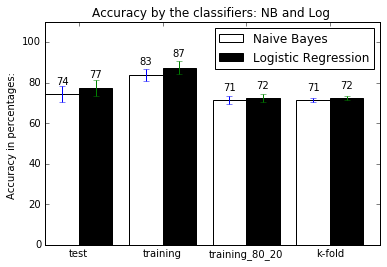

In [37]:
groups = 4

# naive_bayes_means = (naive_test_accuracy, naive_bayes_training_accuracy, naive_training_80_20_accuracy, 
                    #naive_10_fold_accuracy)
naive_bayes_means = (74.37, 83.6, 71.5, 71.34)
naive_bayes_std = (4, 3, 2, 1)

# logistic_regression_means = (logistic_test_accuracy, log_training_accuracy, log_training_80_20_accuracy 
                             #log_10_fold_accuracy)
logistic_regression_means = (77.4, 87.4, 72.6, 72.28)

logistic_regression_std = (4, 3, 2, 1)

width = 0.40
ind_1 = np.arange(groups)
fig, ax = pp.subplots()
rects1 = ax.bar(ind_1, naive_bayes_means, width, color='w', yerr=naive_bayes_std)
rects2 = ax.bar(ind_1 + width, logistic_regression_means, width, color='k', yerr=logistic_regression_std)

ax.set_ylabel('Accuracy in percentages: ')
ax.set_title('Accuracy by the classifiers: NB and Log ')
ax.set_xticks(ind_1 + width)
ax.set_xticklabels(('test', 'training', 'training_80_20', 'k-fold'))
pp.ylim(ymax = 110, ymin = 0)

ax.legend((rects1[0], rects2[0]), ('Naive Bayes', 'Logistic Regression'))

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


pp.figure(figsize=(30,20))

pp.show()

# ROC curve for Logistic Regression on test.csv

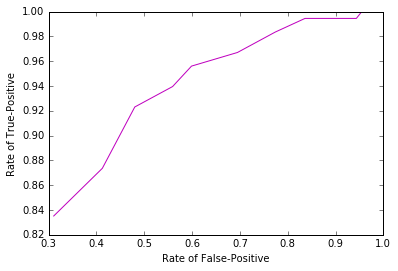

In [30]:
%matplotlib inline
pp.plot(falsePositiveRate_list, truePositiveRate_list, color='m')
pp.xlabel("Rate of False-Positive")
pp.ylabel("Rate of True-Positive")
pp.show()